In [1]:
%matplotlib inline
import io
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

c:\users\hjl161\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
datafile_AMT = '../data/MTurk_anonymous.xlsx'
#datafile_DTU1 = '../data/DTU1_anonymous.xlsx'
#datafile_DTU2 = '../data/DTU2_anonymous.xlsx'

In [3]:
df_MTurk = pd.DataFrame(pd.read_excel(datafile_AMT))
df_MTurk.drop(df_MTurk.columns[df_MTurk.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
#df_DTU1 = pd.DataFrame(pd.read_excel(datafile_DTU1))
#df_DTU1.drop(df_DTU1.columns[df_DTU1.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
#df_DTU2 = pd.DataFrame(pd.read_excel(datafile_DTU2))
#df_DTU2.drop(df_DTU2.columns[df_DTU2.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In the following, we want to partition responses according to how many times a player has miscoordinated before. For a start, we concatenate all three experiments into one dataframe:

In [4]:
#dfd = pd.concat([
#                 df_MTurk.join(pd.Series(['MTurk']*len(df_MTurk), name='experiment')), 
#                df_DTU1.join(pd.Series(['DTU1']*len(df_DTU1), name='experiment')),
#                df_DTU2.join(pd.Series(['DTU2']*len(df_DTU2), name='experiment'))],
#                ignore_index=True)

In [5]:
df_MTurk.head(), len(df_MTurk)

(    session      code  group  id_in_group  round  arrival  choice  certainty  \
 0  0c0pdasz  zh74wr23      2            1      1      8.2       1      0.875   
 1  0c0pdasz  w73mxa5y      2            2      1      8.3       1      0.875   
 2  0c0pdasz  zh74wr23      2            1      2      8.2       0      0.500   
 3  0c0pdasz  w73mxa5y      2            2      2      8.1       1      0.875   
 4  0c0pdasz  zh74wr23      2            1      3      8.2       1      0.990   
 
    bonus strategy  simple  cutoff  fault  payoff  
 0  -0.13      NaN     NaN     NaN    NaN    7.89  
 1  -0.13      NaN     NaN     NaN    NaN    4.66  
 2  -1.39      NaN     NaN     NaN    NaN    7.89  
 3  -4.16      NaN     NaN     NaN    NaN    4.66  
 4  -0.01      NaN     NaN     NaN    NaN    7.89  , 4260)

Now we group the data into response pairs

In [6]:
df = df_MTurk.groupby(['session', 'group', 'round'], as_index=False)[['code', 'id_in_group', 'arrival', 'choice', 'certainty']].agg(lambda x: tuple(x))
df.head()

,session,group,round,code,id_in_group,arrival,choice,certainty
0,0c0pdasz,2,1,"(zh74wr23, w73mxa5y)","(1, 2)","(8.2, 8.3)","(1, 1)","(0.875, 0.875)"
1,0c0pdasz,2,2,"(zh74wr23, w73mxa5y)","(1, 2)","(8.2, 8.1)","(0, 1)","(0.5, 0.875)"
2,0c0pdasz,2,3,"(zh74wr23, w73mxa5y)","(1, 2)","(8.2, 8.3)","(1, 1)","(0.99, 0.625)"
3,0c0pdasz,2,4,"(zh74wr23, w73mxa5y)","(1, 2)","(8.4, 8.5)","(1, 1)","(0.625, 0.625)"
4,0c0pdasz,2,5,"(zh74wr23, w73mxa5y)","(1, 2)","(9.1, 9.0)","(0, 0)","(0.99, 0.99)"


In [7]:
# initialize new dataframes that will hold data with a condition. df0 will contain all choices 
# having had zero previous miscoordinations, while df1_ will contain all choices having had one
# or more previous miscoordinations
df0 = pd.DataFrame(columns=df.columns)
df1_ = pd.DataFrame(columns=df.columns)

In [8]:
# partition the dataframe into two bins - the first having 0 and 1, and the other 2 or more
# miscoordinations:
sessions = df.session.unique()
for session in sessions:
    df_session = df[df.session == session]
    groups = df_session.group.unique()
    for group in groups:
        df_group = df_session[df_session.group == group]
        miss = 0
        for idx, row in df_group.iterrows():
            if sum(row['choice']) != 1:
                if miss == 0:
                    df0 = df0.append(row, ignore_index=True)
                else:
                    df1_ = df1_.append(row, ignore_index=True)
            else:
                if miss == 0:
                    df0 = df0.append(row, ignore_index=True)
                else:
                    df1_ = df1_.append(row, ignore_index=True)
                miss += 1

Now a bit of magic: we need to separate the tuples again and create rows for each person: (see ref at https://stackoverflow.com/questions/53218931/how-to-unnest-explode-a-column-in-a-pandas-dataframe

In [9]:
def unnesting(df, explode):
    idx = df.index.repeat(df[explode[0]].str.len())
    df1 = pd.concat([
        pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1)
    df1.index = idx

    return df1.join(df.drop(explode, 1), how='left')


dfnew0 = unnesting(df0,['code', 'id_in_group', 'arrival', 'choice', 'certainty'])
dfnew1_ = unnesting(df1_,['code', 'id_in_group', 'arrival', 'choice', 'certainty'])

In [10]:
dfnew0['arrival'].replace({9.0: 8.6, 9.1: 8.7}, inplace=True)
dfnew1_['arrival'].replace({9.0: 8.6, 9.1: 8.7}, inplace=True)
len(dfnew0), len(dfnew1_)

(2762, 1498)

In [11]:
dfnew0.head()

,code,id_in_group,arrival,choice,certainty,session,group,round
0,zh74wr23,1,8.2,1,0.875,0c0pdasz,2,1
0,w73mxa5y,2,8.3,1,0.875,0c0pdasz,2,1
1,zh74wr23,1,8.2,0,0.500,0c0pdasz,2,2
1,w73mxa5y,2,8.1,1,0.875,0c0pdasz,2,2
2,3ukm8x0z,1,8.7,0,0.750,0c0pdasz,3,1


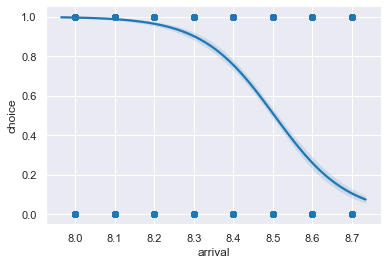

In [12]:
sns.regplot(x='arrival', y='choice', data=dfnew0, ci=95, logistic=True)
sns.despine()

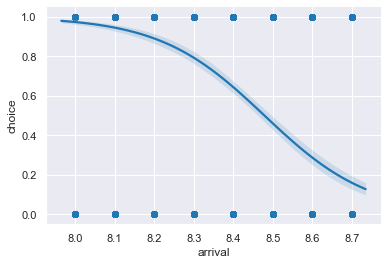

In [13]:
sns.regplot(x='arrival', y='choice', data=dfnew1_, ci=95, logistic=True)
sns.despine()

In [14]:
dfall = pd.concat([dfnew0.join(pd.Series(['zero']*len(dfnew0), name='miss')), 
                   dfnew1_.join(pd.Series(['one_or_more']*len(dfnew1_), name='miss'))],
                ignore_index=True)

In [15]:
dfall.head()

,code,id_in_group,arrival,choice,certainty,session,group,round,miss
0,zh74wr23,1,8.2,1,0.875,0c0pdasz,2,1,zero
1,w73mxa5y,2,8.3,1,0.875,0c0pdasz,2,1,zero
2,zh74wr23,1,8.2,0,0.500,0c0pdasz,2,2,zero
3,w73mxa5y,2,8.1,1,0.875,0c0pdasz,2,2,zero
4,3ukm8x0z,1,8.7,0,0.750,0c0pdasz,3,1,zero


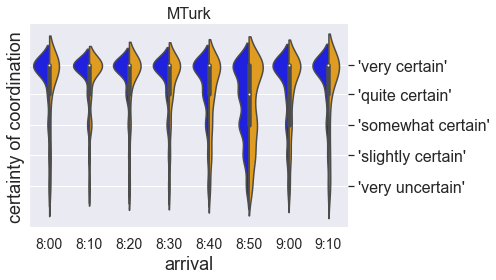

In [16]:
fig, ax = plt.subplots(figsize=(7,4))
ax = sns.violinplot(x='arrival', y='certainty', hue="miss", palette=['blue', 'orange'], split=True, data=dfall)
ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")
plt.ylabel('certainty of coordination', fontsize=18)
plt.xlabel('arrival', fontsize=18)
ax.set_xticklabels(["8:00", "8:10", "8:20", "8:30", "8:40", "8:50", "9:00", "9:10"], fontsize=14)
plt.yticks([.5, .625, .75, .875, .99], ['\'very uncertain\'', '\'slightly certain\'', '\'somewhat certain\'', '\'quite certain\'', '\'very certain\''], fontsize=16)
ax.legend_.remove()
plt.title('MTurk', fontsize=16)
plt.tight_layout()

plt.rcParams["font.family"] = "sans-serif"
PLOTS_DIR = '../plots'
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

plt.savefig(os.path.join(PLOTS_DIR, 'figS7_certainties_MTurk.png'),
            bbox_inches='tight', transparent=True, dpi=300)
plt.savefig(os.path.join(PLOTS_DIR, 'figS7_certainties_MTurk.pdf'), transparent=True, dpi=300)
sns.despine()